In [307]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from tensorflow_addons.layers import InstanceNormalization

def check_tensorflow_gpu():
    sys_info = tf.sysconfig.get_build_info()
    cuda_version, cudnn_version = sys_info['cuda_version'], sys_info['cudnn_version']
    num_gpu_avail = len(tf.config.experimental.list_physical_devices('GPU'))
    gpu_name = device_lib.list_local_devices()[1].physical_device_desc[17:40]
    print('... Checking Tensorflow Version ...')
    print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
    print("TF: {} | CUDA: {} | cuDNN: {}".format(tf.__version__, cuda_version, cudnn_version))
    print('# GPU available: {} ({})'.format(num_gpu_avail, gpu_name))
    print(tf.config.list_physical_devices())
    return None
#check_tensorflow_gpu()

In [295]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding="same")
        self.flatten    = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches
    
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(input_dim=num_tokens, output_dim=self.embed_dim)
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens    = encoded_tokens + encoded_positions
        return encoded_tokens

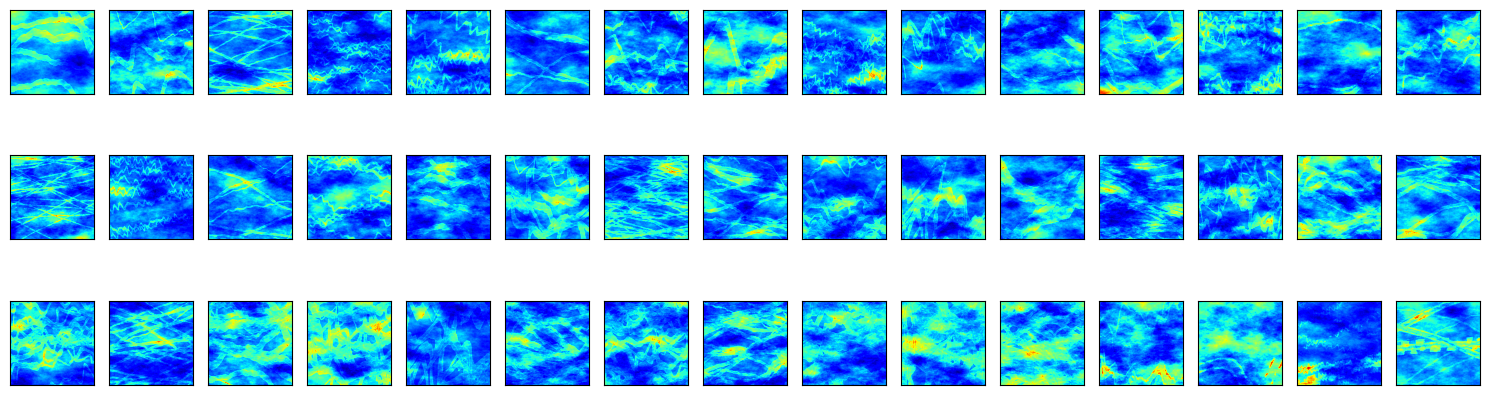

In [300]:
plt.figure(figsize=(15,5))
for i in range(45):
    temp = np.load('h2dataf/X_data/x{}.npy'.format(i+1))
    plt.subplot(3,15,i+1)
    plt.imshow(temp[0], cmap='jet')
    plt.xticks([]); plt.yticks([])
plt.tight_layout(); plt.show()

In [259]:
DATASET_NAME   = 'organmnist3d'
BATCH_SIZE     = 32
AUTO           = tf.data.AUTOTUNE
INPUT_SHAPE    = (60,128,128,3)
NUM_CLASSES    = 2

PATCH_SIZE     = (4,4,4)
NUM_PATCHES    = (INPUT_SHAPE[0] // PATCH_SIZE[0]) **2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS      = 16
NUM_LAYERS     = 8

EPOCHS         = 50
LEARNING_RATE  = 1e-4
WEIGHT_DECAY   = 1e-5

In [291]:
def create_vivit_model(tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE), 
                       positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM), 
                       input_shape=INPUT_SHAPE, transformer_layers=NUM_LAYERS, num_heads=NUM_HEADS, embed_dim=PROJECTION_DIM, 
                       layer_norm_eps=LAYER_NORM_EPS, attn_dropout=0.1, st_dropout=0.1):
    K.clear_session()
    def decoder_layer(inp, filters, kernel_size=3):
        #x = layers.TimeDistributed(layers.SeparableConv2D(filters=filters, kernel_size=kernelsize, padding='same'))(inp)
        x = layers.ConvLSTM2D(filters=filters, kernel_size=kernel_size, padding='same', return_sequences=True)(inp)
        x = InstanceNormalization()(x)
        x = tf.nn.gelu(x)
        x = layers.TimeDistributed(layers.SpatialDropout2D(rate=st_dropout))(x)
        x = layers.TimeDistributed(layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, padding='same', strides=2, activation='gelu'))(x)
        return x

    inputs          = layers.Input(shape=input_shape)
    patches         = tubelet_embedder(inputs)
    encoded_patches = positional_encoder(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads, dropout=attn_dropout)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
        x3 = keras.Sequential([layers.Dense(units=embed_dim*4, activation=tf.nn.gelu),
                               layers.Dense(units=embed_dim,   activation=tf.nn.gelu)])(x3)
        encoded_patches = layers.Add()([x3, x2])
        
    _ = layers.Reshape(target_shape = tuple([INPUT_SHAPE[i]//PATCH_SIZE[i] for i in range(len(PATCH_SIZE))] + [encoded_patches.shape[-1]]))(encoded_patches)
    _ = decoder_layer(_, filters=64)
    _ = decoder_layer(_, filters=32)

    outputs = layers.TimeDistributed(layers.Conv2DTranspose(filters=2, kernel_size=3, padding='same', activation='sigmoid'))(_)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [292]:
model = create_vivit_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 128, 128, 3)]    0         []                            
                                                                                                  
 tubelet_embedding_1 (Tubel  (None, 15360, 128)           24704     ['input_1[0][0]']             
 etEmbedding)                                                                                     
                                                                                                  
 positional_encoder_1 (Posi  (None, 15360, 128)           1966080   ['tubelet_embedding_1[0][0]'] 
 tionalEncoder)                                                                                   
                                                                                              

***

In [22]:
def download_and_prepare_dataset(data_info: dict):
    data_path = keras.utils.get_file(origin=data_info["url"], md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return ((train_videos, train_labels), (valid_videos, valid_labels), (test_videos, test_labels))

info = medmnist.INFO[DATASET_NAME]
prepared_dataset = download_and_prepare_dataset(info)
(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos,  test_labels)  = prepared_dataset[2]

In [28]:
@tf.function
def preprocess(frames:tf.Tensor, label:tf.Tensor):
    frames = tf.image.convert_image_dtype(frames[..., tf.newaxis], tf.float32)
    label  = tf.cast(label, tf.float32)
    return frames, label

def prepare_dataloader(videos:np.ndarray, labels:np.ndarray, loader_type:str="train", batch_size:int=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))
    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)
    dataloader = (dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE))
    return dataloader

trainloader = prepare_dataloader(train_videos, train_labels, "train")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
testloader  = prepare_dataloader(test_videos, test_labels, "test")

***

In [96]:
def run_experiment():
    model = create_vivit_classifier(tubelet_embedder   = TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE),
                                    positional_encoder = PositionalEncoder(embed_dim=PROJECTION_DIM))

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

    fit = model.fit(trainloader, 
                    epochs          = EPOCHS, 
                    validation_data = validloader, 
                    verbose         = 0)
    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    print('Test: Accuracy={:.4f}% | Top-5 Accuracy={:.4f}%'.format(accuracy*100, top_5_accuracy*100))
    return model, fit

model, fit = run_experiment()

20/20 [==============================] - 1s 34ms/step - loss: 0.9574 - accuracy: 0.8000 - top-5-accuracy: 0.9770
Test: Accuracy=80.0000% | Top-5 Accuracy=97.7049%


***
# END